# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the accuracy of the SVM classifier on the training data and on lab samples.
The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common import trinary_data
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common import transform_data

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
PROVIDER = DataProvider()
PROVIDER.do()
DATA = TrinaryData(is_regulator=False, is_dropT1=True, is_averaged=True)
DF_X = DATA.df_X
SER_Y = DATA.ser_y
STAGE_NAMES = PROVIDER.getStageNames(SER_Y)

In [3]:
CLASSIFIER = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=10, size=100)
CLASSIFIER.fit(DATA.df_X, DATA.ser_y)

In [4]:
# GO Terms for the genes
df_go_terms = PROVIDER.df_go_terms.set_index("GENE_ID")
for gene in CLASSIFIER.features:
    if gene in df_go_terms.index:
        print("%s: %s" % (gene, df_go_terms.loc[gene, "GO_Term"]))

Rv2385: triglyceride lipase activity
Rv3083: response to acidic pH---growth of symbiont in host cell---cell wall
Rv2382c: growth
Rv2958c: glycolipid biosynthetic process---pathogenesis---evasion or tolerance of host immune response---UDP-glycosyltransferase activity---transferase activitytransferring hexosyl groups---plasma membrane---intracellular membrane-bounded organelle
Rv3841: response to hypoxia---iron assimilation by chelation and transport---response to nitrosative stress---ferroxidase activity---iron ion binding---extracellular region---cell wall---cytosol---plasma membrane
Rv0040c: extracellular region
Rv3136: cell wall


## Helper Functions

In [5]:
def getStage(states):
    """
    Provides the name of the stage for the value of a state.
    
    Parameters
    ----------
    states: list-int
    """
    timepoints = []
    for state in states:
        timepoint = [i for i, v in SER_Y.iteritems() if v == state][0]
        timepoints.append(timepoint)
    return list(PROVIDER.getStages(timepoints))

# TESTS
assert(getStage([0, 1])[1] == "Transition")

In [16]:
def plotExpressionLevels(df_X, features, ser_y=None, is_plot=True, title=""):
    """
    Heat map of expression levels. Shades states.
    
    Parameters
    ----------
    df_X: DataFrame (feature vector)
    features: list-str
    """
    # Internal constants
    ROTATION = 30
    FONTSIZE = 14
    # Shade replications
    fig, ax = plt.subplots(1, figsize=(20, 5))
    columns = list(features)
    columns.sort()
    new_df_X = df_X[columns]
    sns.heatmap(new_df_X.T, cmap="seismic", ax=ax)
    # Shade the classes
    if ser_y is not None:
        alphas = [0.0, 0.4]
        alpha_idx = 0
        for idx, val in enumerate(ser_y.values):
            stage = getStage([val])[0]
            if (idx == 0):
                ax.text(idx, 0, "%s" % stage, fontsize=FONTSIZE, rotation=ROTATION)
            elif ser_y.values[idx-1] != val:
                ax.text(idx, 0, "%s" % stage, fontsize=FONTSIZE, rotation=ROTATION)
                alpha_idx = 1 - alpha_idx
            ax.axvspan(idx, idx+1, facecolor='grey', alpha=alphas[alpha_idx])
    # Other plot characteristics
    ax.set_title(title, fontsize=18)
    #
    if is_plot:
        plt.show()
    else:
        plt.close()
    
# Tests
plotExpressionLevels(DF_X, CLASSIFIER.features, SER_Y, is_plot=False)

In [17]:
def sortColumns(df):
    columns = list(df.columns)
    columns.sort()
    df.columns = columns
    df = df.sort_index()
    return df

In [18]:
def getSampleData(**kwargs):
    sample_data = trinary_data.getSampleData(**kwargs)
    dct = {}
    for sample in trinary_data.SAMPLES:
        dct[sample] = sortColumns(sample_data.__getattribute__(sample))
    return dct
        
SAMPLE_BIOREACTOR_REF_DCT = getSampleData(is_regulator=False, is_bioreactor_ref=True)
SAMPLE_NOTBIOREACTOR_REF_DCT = getSampleData(is_regulator=False, is_bioreactor_ref=False)

# Training Data
Data used in the analysis.

In [7]:
DATA.df_X.head()

,Rv1927,Rv1129c,Rv3085,Rv3083,Rv3086,Rv2226,Rv0260c,Rv1365c,Rv3084,Rv0975c,...,Rv3267,Rv2748c,Rv3260c,Rv0350,Rv2737c,Rv0440--Rv3417c,Rv2734,Rv0519c,Rv3418c,Rv3269
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [8]:
SER_Y.head()

timepoint
T2    1
T3    1
T4    1
T5    1
T6    1
Name: name, dtype: int64

# BioReactor Data

In [9]:
DF_X

,Rv1927,Rv1129c,Rv3085,Rv3083,Rv3086,Rv2226,Rv0260c,Rv1365c,Rv3084,Rv0975c,...,Rv3267,Rv2748c,Rv3260c,Rv0350,Rv2737c,Rv0440--Rv3417c,Rv2734,Rv0519c,Rv3418c,Rv3269
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T8,-1,-1,-1,-1,-1,-1,-1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
T9,-1,-1,-1,-1,-1,-1,-1,-1,0,0,...,0,0,0,0,0,1,1,1,1,1
T10,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,0,1,1,1
T11,-1,-1,-1,-1,-1,-1,0,0,-1,0,...,0,0,0,0,0,0,1,1,1,1


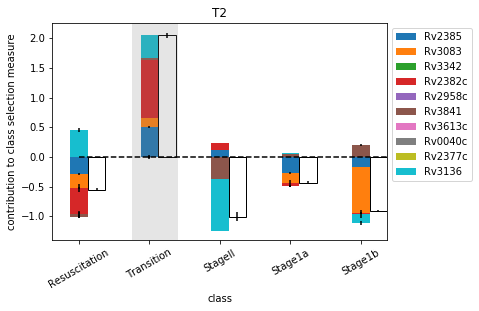

In [10]:
instances = ["T2"]
for instance in instances:
    CLASSIFIER.plotFeatureContributions(DF_X.loc[instance, :],
                    title=instance, true_class=SER_Y.loc[instance],
                    class_names=STAGE_NAMES)

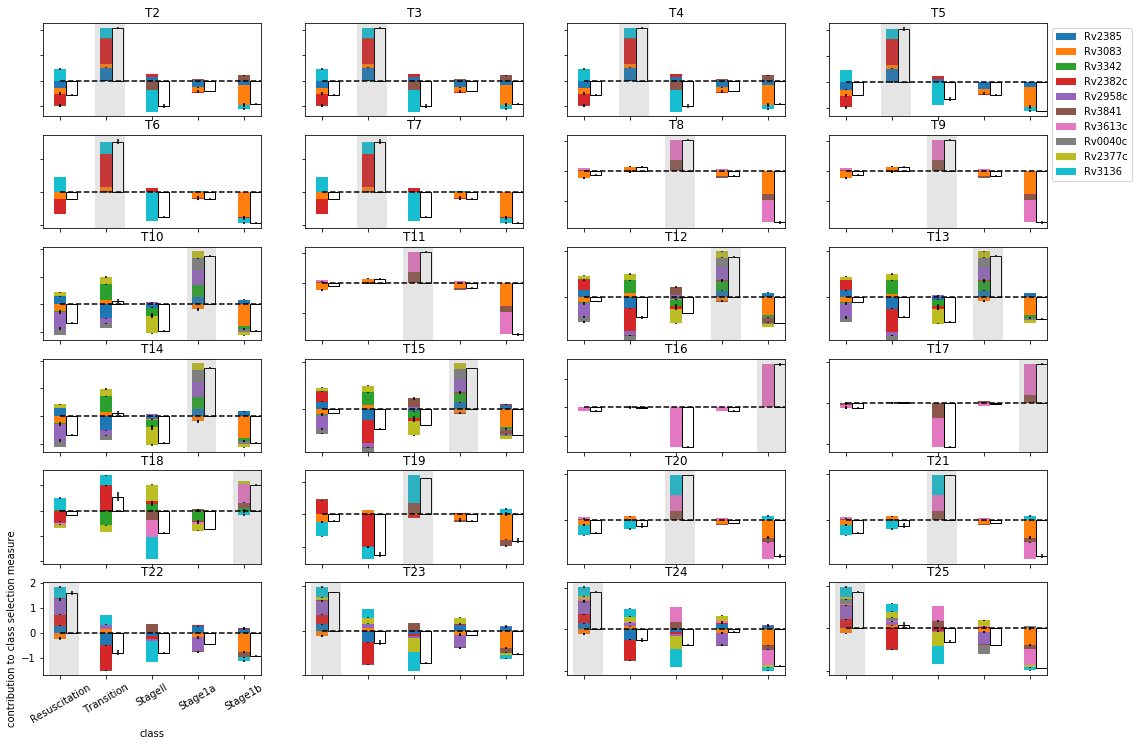

In [14]:
nrow = 6
ncol = 4
_, axes = plt.subplots(nrow, ncol, figsize=(18,12))
for irow in range(nrow):
    for icol in range(ncol):
        ax = axes[irow, icol]
        instance_num = irow*ncol + icol + 2
        instance = "T%d" % instance_num
        if instance not in DATA.df_X.index:
            break
        ser_X = DATA.df_X.loc[instance, :]
        if (icol + 1 == ncol) and (irow==0):
            is_legend = True
        else:
            is_legend = False
        if (icol == 0) and (irow + 1 == nrow):
            is_ylabel = True
            is_xlabel = True
        else:
            is_ylabel = False
            is_xlabel = False
        CLASSIFIER.plotFeatureContributions(ser_X, ax=ax,
                title=instance, true_class=DATA.ser_y.loc[instance], is_plot=False, is_legend=is_legend,
                                           class_names=STAGE_NAMES,
                                           is_xlabel=is_xlabel, is_ylabel=is_ylabel)
plt.show()

# Lab Samples

## AM, MDM

In [20]:
SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"]

,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AM_D20_1,0,1,0,0,-1,1,0,0,0,0,...,-1,1,-1,0,-1,-1,-1,-1,-1,-1
AM_D20_3,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AM_D20_4,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AM_D20_5,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
MDM_D20_1,1,0,0,0,-1,1,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
MDM_D20_3,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,0,-1,-1,-1,-1,-1
MDM_D20_4,1,0,1,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
MDM_D20_5,0,1,1,-1,-1,1,-1,0,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Evaluations

### Difference between bioreactor and not bioreactor

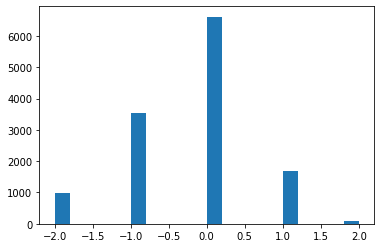

In [21]:
df = SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"] - SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"]
df = df.T.dropna(axis=1, how='all').T
_ = plt.hist(df.values.flatten(), bins=20)

### Details for classifier genes

In [22]:
# Analysis of the top 10 genes
svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=20, size=100)
svm_ensemble.fit(DATA.df_X, DATA.ser_y)

In [23]:
svm_ensemble.features

['Rv2385',
 'Rv3083',
 'Rv3342',
 'Rv2382c',
 'Rv2958c',
 'Rv3841',
 'Rv3613c',
 'Rv0040c',
 'Rv2377c',
 'Rv3136',
 'Rv2329c',
 'Rv2380c',
 'Rv0886',
 'Rv1479',
 'Rv1700',
 'Rv1642',
 'Rv2736c',
 'Rv1461',
 'Rv0287',
 'Rv0860']

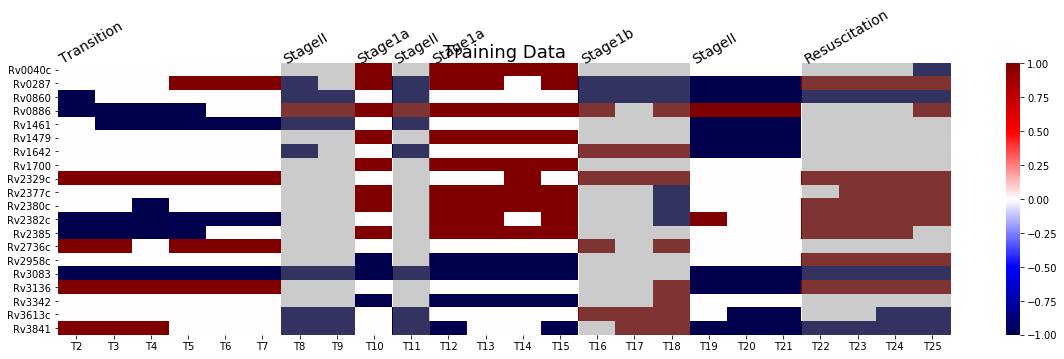

In [24]:
# Deeper look at training data
plotExpressionLevels(DATA.df_X, svm_ensemble.features, ser_y=DATA.ser_y, title="Training Data")

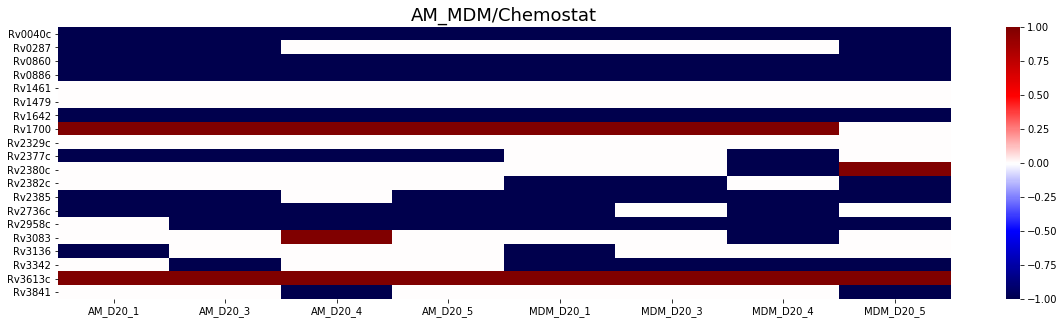

In [25]:
# Differences between chemostat and non-chemostat data
plotExpressionLevels(SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"], svm_ensemble.features, title="AM_MDM/Chemostat")

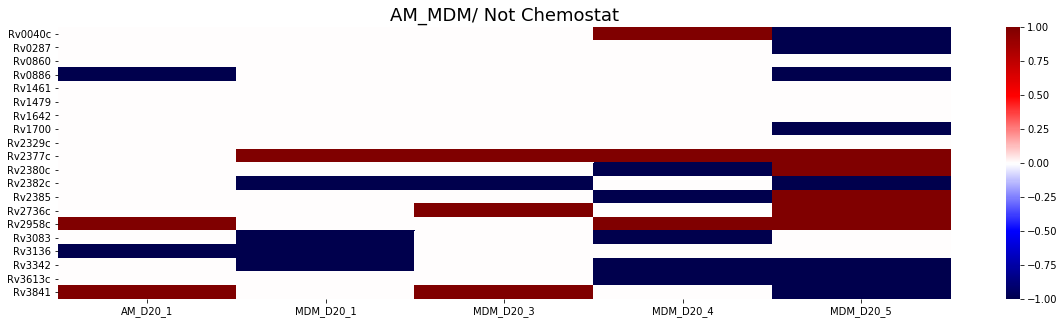

In [26]:
# Differences between chemostat and non-chemostat data
plotExpressionLevels(SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"], svm_ensemble.features, title="AM_MDM/ Not Chemostat")

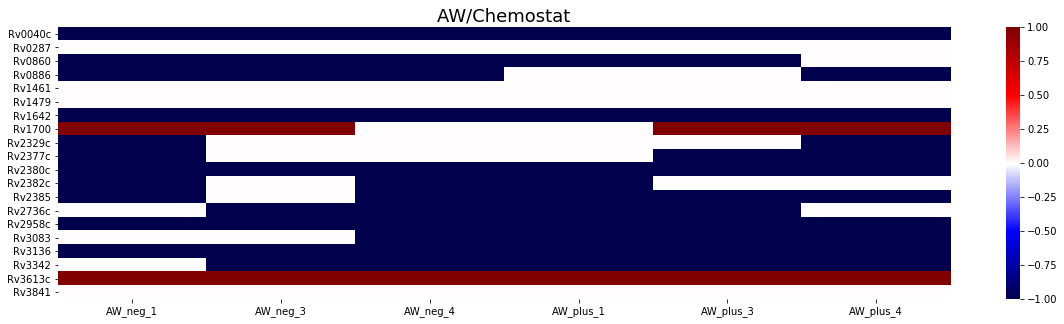

In [27]:
# Differences between chemostat and non-chemostat data
plotExpressionLevels(SAMPLE_BIOREACTOR_REF_DCT["AW"], svm_ensemble.features, title="AW/Chemostat")

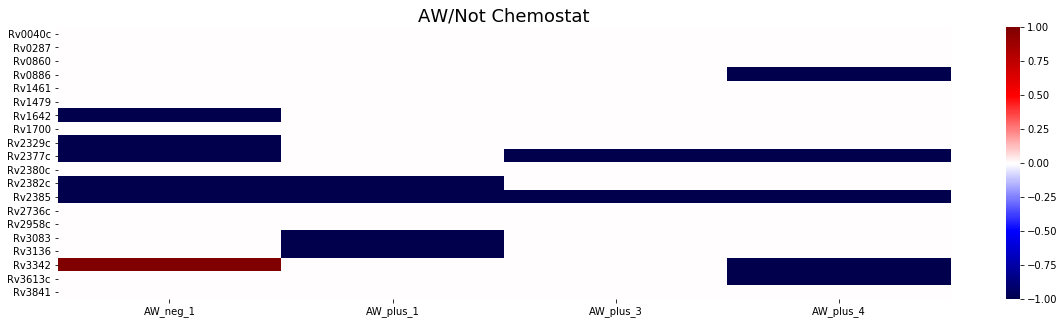

In [28]:
# Differences between chemostat and non-chemostat data
plotExpressionLevels(SAMPLE_NOTBIOREACTOR_REF_DCT["AW"], svm_ensemble.features, title="AW/Not Chemostat")

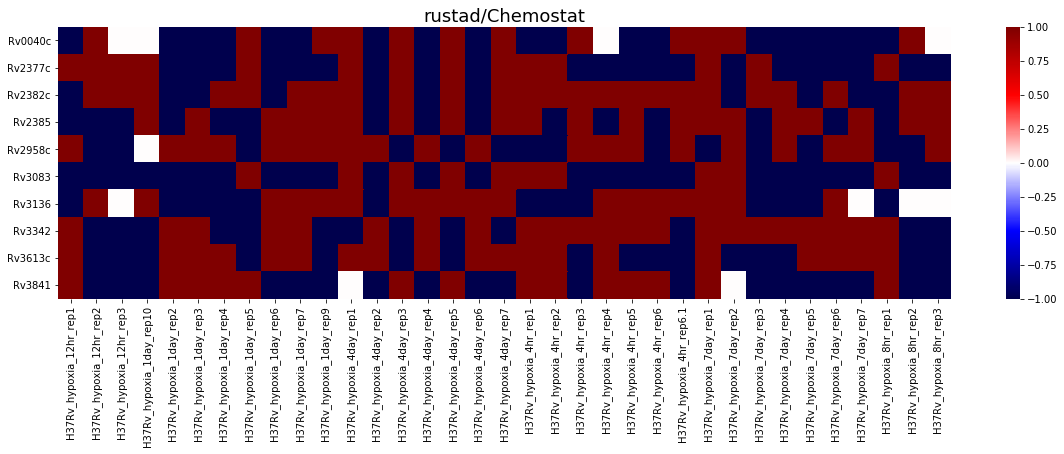

In [29]:
df = SAMPLE_BIOREACTOR_REF_DCT["rustad"]
time_keys = np.array(["H37Rv_hypoxia_4hr", "H37Rv_hypoxia_8hr", "H37Rv_hypoxia_12hr",
                      "H37Rv_hypoxia_1day", "H37Rv_hypoxia_4day", "H37Rv_hypoxia_7day"])
indices = [i for i in df.index if any([t in i for t in time_keys])]
df = df.loc[indices, :]
plotExpressionLevels(df, CLASSIFIER.features, title="rustad/Chemostat")

# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [ ]:
if False:
    accuracy_dct = {}
    for rank in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        accuracy_dct[rank] = classifier_ensemble.ClassifierEnsemble.crossValidate(
            DATA, num_iter=10, num_holdout=1, filter_high_rank=rank, size=20)
    plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
    plt.ylim([0, 1.1])
    _ = plt.xlabel("No genes in clasifier")
    _ = plt.ylabel("accuracy")

# Classification of Other Samples

In [30]:
CLASSIFIER.features

['Rv2385',
 'Rv3083',
 'Rv3342',
 'Rv2382c',
 'Rv2958c',
 'Rv3841',
 'Rv3613c',
 'Rv0040c',
 'Rv2377c',
 'Rv3136']

In [31]:
CLASSIFIER.predict(SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"])

,0,1,2,3,4
AM_D20_1,0.0,0.00,0.02,0.0,0.98
AM_D20_3,0.0,0.00,0.00,0.0,1.00
AM_D20_4,0.0,0.00,0.00,0.0,1.00
AM_D20_5,0.0,0.00,0.00,0.0,1.00
MDM_D20_1,0.0,0.93,0.00,0.0,0.07
MDM_D20_3,0.0,0.98,0.00,0.0,0.02
MDM_D20_4,0.0,0.96,0.00,0.0,0.04
MDM_D20_5,0.0,0.98,0.00,0.0,0.02


In [32]:
CLASSIFIER.predict(SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"])

,0,1,2,3,4
AM_D20_1,0.00,0.00,0.04,0.0,0.96
MDM_D20_1,0.00,0.98,0.02,0.0,0.00
MDM_D20_3,0.00,1.00,0.00,0.0,0.00
MDM_D20_4,0.00,0.98,0.02,0.0,0.00
MDM_D20_5,0.02,0.98,0.00,0.0,0.00


In [ ]:
# Combine states - 0 + 4 == neg; 1,2,3 = pos
# Use uncurated baseline for AW, others?

In [43]:
def reportSamplePredictions(sample_dct):
    for sample, df_X in sample_dct.items():
        print("\n\n%s" % sample)
        df = CLASSIFIER.predict(df_X)
        df.columns = STAGE_NAMES[np.array(df.columns)]
        print(df)

In [44]:
reportSamplePredictions(SAMPLE_NOTBIOREACTOR_REF_DCT)



AM_MDM
           Resuscitation  Transition  StageII  Stage1a  Stage1b
AM_D20_1            0.00        0.00     0.04      0.0     0.96
MDM_D20_1           0.00        0.98     0.02      0.0     0.00
MDM_D20_3           0.00        1.00     0.00      0.0     0.00
MDM_D20_4           0.00        0.98     0.02      0.0     0.00
MDM_D20_5           0.02        0.98     0.00      0.0     0.00


AW
           Resuscitation  Transition  StageII  Stage1a  Stage1b
AW_neg_1             0.0         0.0      1.0      0.0      0.0
AW_plus_1            0.0         0.0      1.0      0.0      0.0
AW_plus_3            0.0         0.0      1.0      0.0      0.0
AW_plus_4            0.0         0.0      1.0      0.0      0.0


sherman
   Resuscitation  Transition  StageII  Stage1a  Stage1b
0            0.0         0.0      1.0      0.0      0.0


galagan
***Warning: missing columns in prediction vector. 
 ['Rv3342', 'Rv2385', 'Rv3841', 'Rv2382c']
         Resuscitation  Transition  StageII  Stage1a  St

In [45]:
reportSamplePredictions(SAMPLE_BIOREACTOR_REF_DCT)



AM_MDM
           Resuscitation  Transition  StageII  Stage1a  Stage1b
AM_D20_1             0.0        0.00     0.02      0.0     0.98
AM_D20_3             0.0        0.00     0.00      0.0     1.00
AM_D20_4             0.0        0.00     0.00      0.0     1.00
AM_D20_5             0.0        0.00     0.00      0.0     1.00
MDM_D20_1            0.0        0.93     0.00      0.0     0.07
MDM_D20_3            0.0        0.98     0.00      0.0     0.02
MDM_D20_4            0.0        0.96     0.00      0.0     0.04
MDM_D20_5            0.0        0.98     0.00      0.0     0.02


AW
           Resuscitation  Transition  StageII  Stage1a  Stage1b
AW_neg_1             0.0        0.00     0.95      0.0     0.05
AW_neg_3             0.0        0.00     0.00      0.0     1.00
AW_neg_4             0.0        0.98     0.02      0.0     0.00
AW_plus_1            0.0        0.98     0.02      0.0     0.00
AW_plus_3            0.0        0.00     0.98      0.0     0.02
AW_plus_4            0.0  

# Rustad analysis

In [51]:
# Rustad analysis
df_X = SAMPLE_BIOREACTOR_REF_DCT["rustad"]
df_pred = CLASSIFIER.predict(df_X)
instances = [i for i in df_pred.index if "H37Rv_hypoxia" in i]
df_pred = df_pred.loc[instances, :]
times = []
replications = []
for instance in instances:
    if "hr" in instance:
        pos = instance.index("hr_")
    else:
        pos = instance.index("ay_")
    last_pos = pos + 2
    times.append(instance[0:last_pos])
    if "10" in instance:
        replications.append(instance[-2:])
    else:
        replications.append(instance[-1])
timeArr = np.array(times)
replicationArr = np.array(replications)
indexArr = list(df_pred.index)
indexArr = np.array(indexArr)
#
state_dct = {}
for time in set(times):
    idxs = [p for p, i in enumerate(indexArr) if time in i]
    replications_sub = replicationArr[idxs]
    times_sub = timeArr[idxs]
    state_dct[time] = []
    for instance in indexArr[idxs]:
        max_val = np.max(df_pred.loc[instance, :].values)
        state = [s for s in df_pred.columns if df_pred.loc[instance, s] == max_val][0]
        state_dct[time].append(STAGE_NAMES[state])

In [55]:
time_keys = np.array(["H37Rv_hypoxia_4hr", "H37Rv_hypoxia_8hr", "H37Rv_hypoxia_12hr",
                      "H37Rv_hypoxia_1day", "H37Rv_hypoxia_4day", "H37Rv_hypoxia_7day"])
truncated_time_keys = np.array(["4hr", "8hr", "12hr",
                      "1day", "4day", "7day"])
time_idxs = np.array([list(state_dct.keys()).index(k) for k in time_keys])
repl_dct = {}
for repl in [0, 1, 2]:
    repl_dct[repl] = [state_dct[t][repl] for t in time_keys[time_idxs]]

In [57]:
repl_dct

{0: ['Stage1b',
  'Stage1b',
  'Resuscitation',
  'Stage1b',
  'Transition',
  'Stage1b'],
 1: ['Stage1b', 'StageII', 'StageII', 'StageII', 'Stage1a', 'StageII'],
 2: ['StageII', 'StageII', 'Stage1b', 'Stage1a', 'Stage1a', 'StageII']}

In [49]:
repl_dct

{0: [4, 4, 0, 4, 1, 4], 1: [4, 2, 2, 2, 3, 2], 2: [2, 2, 4, 3, 3, 2]}

Text(0, 0.5, 'state')

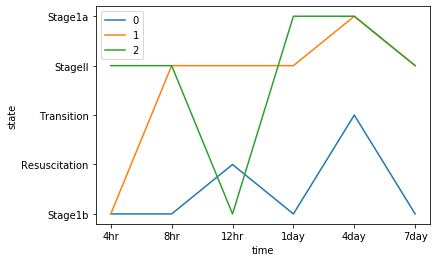

In [58]:
_, ax = plt.subplots(1)
for repl in range(3):
    ax.plot(truncated_time_keys, repl_dct[repl])
plt.legend(range(3))
plt.xlabel("time")
plt.ylabel("state")

# AW Analysis

In [59]:
SAMPLE_BIOREACTOR_REF_DCT["AW"]

,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AW_neg_1,1,1,0,0,-1,1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_neg_3,1,0,0,0,-1,1,0,0,0,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_neg_4,0,1,0,0,-1,1,-1,0,0,0,...,0,0,-1,-1,0,-1,-1,0,-1,-1
AW_plus_1,0,0,0,0,-1,0,-1,0,0,0,...,0,0,-1,0,-1,0,-1,0,0,-1
AW_plus_3,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,0,-1,-1,-1,-1,-1,-1
AW_plus_4,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,-1,-1,-1,-1,-1,-1,1


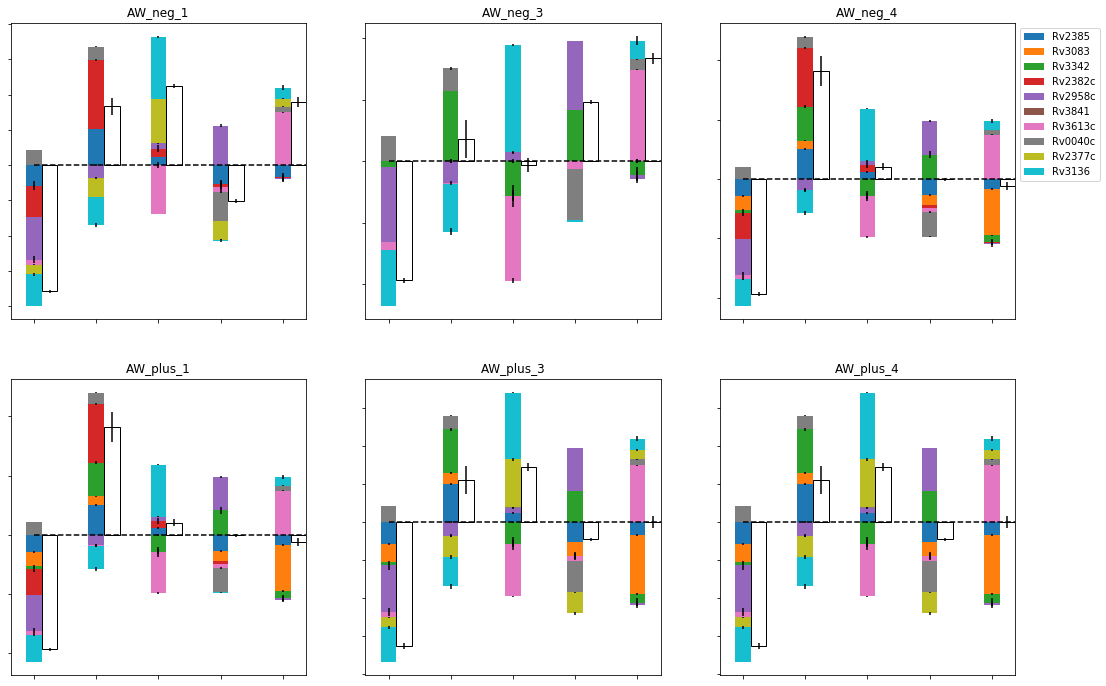

In [61]:
def plotContributions(df_sample, nrow, ncol, instances=None):
    _, axes = plt.subplots(nrow, ncol, figsize=(18,12))
    if instances is None:
        instances = list(df_sample.index)
    idx = 0
    for irow in range(nrow):
        for icol in range(ncol):
            ax = axes[irow, icol]
            instance = instances[idx]
            idx += 1
            ser_X = df_sample.loc[instance, :]
            if (icol + 1 == ncol) and (irow==0):
                is_legend = True
            else:
                is_legend = False
            if (icol == 0) and (irow + 1 == irow):
                is_ylabel = True
                is_xlabel = True
            else:
                is_ylabel = False
                is_xlabel = False
            CLASSIFIER.plotFeatureContributions(ser_X, ax=ax,
                    title=instance, is_plot=False, is_legend=is_legend,
                                               is_xlabel=is_xlabel, is_ylabel=is_ylabel)
    plt.show()
    
# TESTS
df_sample = SAMPLE_BIOREACTOR_REF_DCT["AW"]
plotContributions(df_sample, 2, 3)